In [11]:
'''libraries'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.preprocessing import  MinMaxScaler

In [8]:
'''data and indexing the time stamp'''

milk = pd.read_csv('../data/monthly-milk-production.csv', index_col='Month')
milk.index = pd.to_datetime(milk.index)

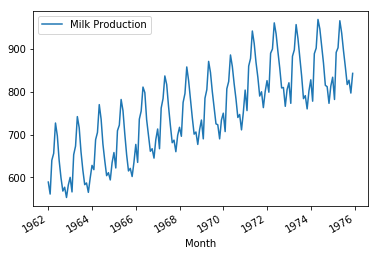

In [12]:
milk.plot()

In [13]:
# splitting the data set in terms of year, rather than random to make the data RNN compatible

train_set, test_set = milk.head(156), milk.tail(12)

In [16]:
# scaling the data

scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.transform(test_set)

In [18]:
# next batch helper function

def next_batch(train_data, batch_size,steps):
    rand_start = np.random.randint(0,len(train_data) - steps) # as we will be adding steps to it again in later steps
    y_batch = np.array(train_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    return y_batch[:,:-1].reshape(-1,steps,1) , y_batch[:,1:].reshape(-1,steps,1)

In [19]:
n_input = 1
num_time_steps = 12
n_neurons = 100
n_output = 1
learn_rate =  0.03
n_iterations = 4000
batch_size = 1

In [20]:
'''place holders'''

x = tf.placeholder(tf.float32,shape=[None,num_time_steps,n_inp])
y = tf.placeholder(tf.float32,shape=[None,num_time_steps,n_opt])

In [23]:
'''projection wrapper'''

cell = tf.contrib.rnn.OutputProjectionWrapper(
tf.contrib.rnn.BasicLSTMCell(num_units=n_neu, activation=tf.nn.relu) ,output_size = n_opt)

In [24]:
outputs, states = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs-y))
optimize = tf.train.AdamOptimizer(learning_rate=lear_rate)

train = optimize.minimize(loss)

In [25]:
saver = tf.train.Saver()

In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        xb,yb = next_batch(train_set,batch_size, num_time_steps)
        sess.run(train,feed_dict = {x:xb,y:yb})
        
        mse = loss.eval(feed_dict = {x:xb,y:yb})
        
    saver.save(sess,"./milk/milk_rnn")

In [28]:
mse

0.002414324

In [31]:
with tf.Session() as sess:
    saver.restore(sess,'./milk/milk_rnn')
    train_seed = list(train_set[-12:])
    
    for i in range(12):
        xb  = np.array(train_seed[-12:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(opts,feed_dict={x:xb})
        
        train_seed.append(y_pred[0,-1,0])
        
        

INFO:tensorflow:Restoring parameters from ./milk/milk_rnn


In [33]:
res = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [42]:
'''generating the future consumption of the milk with trained RNN'''

test_set = milk.tail(12)
test_set['Generated'] = res

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


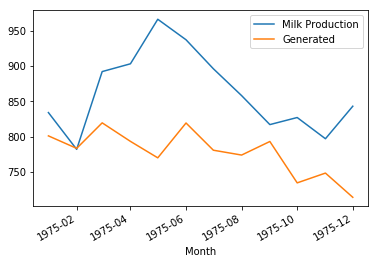

In [43]:
'''generation visualization'''

test_set.plot()